In [1]:
import os
import itertools
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer

import scipy
import librosa
import sed_eval

import matplotlib.pyplot as plt
import matplotlib.cm

import csv
import dcase_util

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
def FeatureExtraction(FilePath,Parameters):
    sr = Parameters['sampling_rate']
    win_size =  Parameters['win_size']
    hop_size = Parameters['hop_size']

    audio_data,audio_sr = librosa.load(FilePath,sr, mono = True)

    #Other Features might be used========================================================
    #audio_mag = np.abs(librosa.stft(audio_data, n_fft=win_size, hop_length=hop_size)) 
    #Short Time Energy
    #ste = ShortTimeEnergy(signal=audio_data,win_size=win_size,hop_size=hop_size)
        #ZCR
    #zcr = librosa.feature.zero_crossing_rate(y=audio_data,frame_length=win_size,hop_length=hop_size)
        #Spectral Centroid
    #cent = librosa.feature.spectral_centroid(y=audio_data, sr=sr,n_fft=win_size, hop_length=hop_size)
        #Spectral Entropy
    #entropy = Spectral_Entropy(y_Mag=audio_mag,sr=sr,n_short_blocks=10)
        #MFCCs and MFCCs with PCEN scaling
    #mfccs, pcens = PCEN_MFCC(y=audio_data,sr=sr,parameters=Parameters)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=20, dct_type=2, norm='ortho')
    pnccs = PNCC(y=audio_data, sr=sr, parameters = Parameters)
    #Flatten all the feature matrix and concatenate them into a 1D vector
    feature_vector = np.concatenate((mfccs,pnccs), axis = 0)
    return feature_vector, audio_data, audio_sr
def PNCC(y,sr,parameters):
    '''
    Calculate the
        MFCCs : Mel-frequency cepstral coefficients (MFCCs)
        PCENs : using PCEN() to replace the log amplitude (dB) scaling on Mel spectra
    '''
    win_size = parameters['win_size']
    hop_size = parameters['hop_size']
    n_mels = parameters['num_mel_filters']
    n_dct = parameters['n_dct']
    fmin = parameters['min_freq']
    fmax = parameters['max_freq']
    mel_spectrogram = librosa.feature.melspectrogram(y=y, 
                                                    sr=sr,
                                                    n_fft=win_size, 
                                                    hop_length=hop_size, 
                                                    power=1, 
                                                    n_mels= n_mels,
                                                    fmin = fmin,
                                                    fmax = fmax)
    
    S_PNCC = librosa.pcen(mel_spectrogram * (2**31))
    
    return scipy.fftpack.dct(S_PNCC, axis=0, type=2, norm='ortho')[:n_dct]
def CreateLabelVector(Data,EventList,Parameters,LabelIndex=1):
    #Given audio data, event list, create its corresponding label vector with given index
    #list for saving number of frame labels. 
    hop_size = Parameters['hop_size']
    audio_sr = Parameters['sampling_rate']
    label_vector = np.zeros(int(np.ceil(len(Data)/hop_size)))                      
    for event in EventList:
        osnet_frame = np.ceil(event['onset'] * audio_sr/hop_size).astype(int)
        offset_frame = np.floor(event['offset'] * audio_sr/hop_size).astype(int)
        label_vector[osnet_frame:offset_frame] = LabelIndex
    return label_vector.astype(int)

def ComputeStateTransition(LabelVector):
        #Calculate the probability of status transition If data contains speech 
        ee_temp = 0 # num of event to event
        nn_temp = 0 # num of none to none
        en_temp = 0 # num of event to none
        ne_temp = 0 # num of none to event
        previous_e = 0 # num of frames with previous is event
        previous_n = 0 # num of frames with previous is none
        if sum(LabelVector) != 0:
            for frame_index in range(len(LabelVector)-1):
                if LabelVector[frame_index] == 0 and LabelVector[frame_index+1] > LabelVector[frame_index]:
                    previous_n = previous_n + 1
                    ne_temp = ne_temp + 1
                elif LabelVector[frame_index] == 0 and LabelVector[frame_index+1] == LabelVector[frame_index]:
                    previous_n = previous_n + 1
                    nn_temp = nn_temp + 1
                elif LabelVector[frame_index] == 1 and LabelVector[frame_index+1] < LabelVector[frame_index]:
                    previous_e = previous_e + 1
                    en_temp = en_temp + 1
                elif LabelVector[frame_index] == 1 and LabelVector[frame_index+1] == LabelVector[frame_index]:
                    previous_e = previous_e + 1
                    ee_temp = ee_temp + 1
            #compute the probability        
            p_ee = ee_temp/previous_e
            p_nn = nn_temp/previous_n
            p_en = en_temp/previous_e
            p_ne = ne_temp/previous_n
        return p_ee,p_nn,p_en,p_ne
#=================================================================================================================
def CreateDataset(Files_Dir,Parameters,Property,EventLabel='speech'):
    #Process all the .wav, .txt, in the assigned folder
    
    #Files_Dir: Target folder for saving all raw audio data
    #Parameters: Using  for processing audio files
    #Property:Create train/test set?
    #EventLabel: The label in string which indicate the class you want to learn

    data = []
    labels = []
    
    #Calculate the Transition Matrix From Training set,saving the probability of each status transition
    SS = []#Speech to Speech
    NN = []#NonSpeech to NonSpeech
    SN = []#Speech to NonSpeech
    NS = []#NonSpeech to Speech
    
    file_index = 0
    for root, dirs,files in os.walk(Files_Dir):
        #.txt-based: which means processing txt first then find its corresponding .wav file
        
        #root_path,subfolders = root,dirs
        for file in os.listdir(root):   
            if file.endswith('.txt'):                
                file_path = root + '/' + file
                print(file_path)
                processed_filename =  os.path.splitext(file)[0]
                #Load Annotated Information
                annotated_event = sed_eval.io.load_event_list(file_path)
                target_event = sed_eval.util.event_list.filter_event_list(annotated_event, scene_label=None, event_label=EventLabel, filename=None)

                #Load Audio for feature extraction
                audio_file_name = os.path.splitext(file)[0] + '.wav'
                audio_file_path = root + '/' + audio_file_name             
                featuree_vector,audio_data, audio_sr = FeatureExtraction(audio_file_path,Parameters)

                #Using Annotation info to create the vector labels
                label_vector = CreateLabelVector(Data=audio_data,
                                                     EventList=target_event,
                                                     Parameters=Parameters,
                                                     LabelIndex=1)                                        

                #Calculate the probability in the transition state matrix If data contains speech 
                if sum(label_vector) != 0:
                    #probability of ss,nn,sn,ns; n=nonspeech, s = speech
                    p_ss, p_nn, p_sn, p_ns = ComputeStateTransition(label_vector)                
                    SS.append(p_ss)
                    NN.append(p_nn)
                    SN.append(p_sn)
                    NS.append(p_ns)

                data.append([featuree_vector,label_vector])
                file_index += 1
    
    #Transition Matrix:
    trans_matrix = np.array([[np.mean(SS),1 - np.mean(SS)],[1 - np.mean(NN),np.mean(NN)]])
    #Saving the transition Matrix
    np.save(os.getcwd()+'/JPNotebookExported/' + Property + '_TransitionMatrix.npy', trans_matrix)
    np.save(os.getcwd()+'/JPNotebookExported/' + Property + '_Dataset.npy', np.asarray(data))
    print(trans_matrix)
    
    return np.asarray(data),trans_matrix

In [3]:
def DatasetLoader(TrainPath,ValidatePath,TestPath):
    #train    
    train_data = np.load(TrainPath,allow_pickle=True)
    #validation    
    validate_data = np.load(ValidatePath,allow_pickle=True)
    #test    
    test_data = np.load(TestPath,allow_pickle=True)

    #Processing all the loaded dataset
    Train = {}
    #Train_Data = np.c_[train_data[:,0].tolist()]
    Train_Data = np.hstack(train_data[:,0].tolist()).transpose()
    Train_Label = np.hstack(train_data[:,1].tolist())
    print(Train_Data.shape)
    print(Train_Label.shape)
    #Train_Label = np.c_[train_data[:,1].tolist()]
    #Train_Data = np.hstack(Train_Data).transpose() #sklearn requires data in [n_samples,n_features]
    #Train_Label = np.hstack(Train_Label)
    Train['Data'] = Train_Data
    Train['Label'] = Train_Label

    Validation = {}
    Validate_Data = np.c_[validate_data[:,0].tolist()]
    Validate_Label = np.c_[validate_data[:,1].tolist()]
    Validate_Data = np.hstack(Validate_Data).transpose() #sklearn requires data in [n_samples,n_features]
    Validate_Label = np.hstack(Validate_Label)
    Validation['Data'] = Validate_Data
    Validation['Label'] = Validate_Label
    print(Validate_Data.shape)
    print(Validate_Label.shape)

    Test = {}
    Test_Data = np.c_[test_data[:,0].tolist()]
    Test_Label = np.c_[test_data[:,1].tolist()]
    Test_Data = np.hstack(Test_Data).transpose() #sklearn requires data in [n_samples,n_features]
    Test_Label = np.hstack(Test_Label)
    Test['Data'] = Test_Data
    Test['Label'] = Test_Label
    print(Test_Data.shape)
    print(Test_Label.shape)
    
    return Train,Validation,Test

def Evaluation(y_true,y_pred,y_pred_prob):
    print('=============precision_recall_fscore_support======================')
    print(metrics.precision_recall_fscore_support(y_true, y_pred, average="binary"))
    print('===================Report=======================')
    print(metrics.classification_report(y_true, y_pred))
    print('===================Accuracy=======================')
    print(metrics.accuracy_score(y_true, y_pred,normalize=True,sample_weight=None))
    print('===================ConfusionMatrix=======================')
    c_matrix = metrics.confusion_matrix(y_true, y_pred)
    plt.figure(1)
    plot_confusion_matrix(c_matrix, classes=[0, 1], normalize = True, title='Confusion matrix with normalization')
    plt.show()

    print('===================ROC curve======================')
    #Roc Auc
    fpr, tpr, thresholds = metrics.roc_curve(y_true,y_pred)
    plt.figure(2)
    plt.plot(fpr, tpr, label='RF')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    print('===================AUC score=======================')
    print(metrics.roc_auc_score(y_true,y_pred))

In [59]:
def Write_Estimated_Annotation(Predicted_Label_Vector,AnAnnotation,AllAnnotations,Parameters):
    '''
    Predicted_Label_Vector:The predicted label vector generated by classifier
    AnAnnotation: a list for only storing a pair of onset&offset for single event
    AllAnnotaions: the list for storing multiple AnAnnotation-lists for one processing file.
    '''
    for i in range(len(Predicted_Label_Vector)-1):
                    #If next frame is different with current frame
                    if Predicted_Label_Vector[i] != Predicted_Label_Vector[i+1]:
                        #Next Frame:Speech; 
                        if Predicted_Label_Vector[i+1] - Predicted_Label_Vector[i] > 0:
                            #Append this Onset
                            AnAnnotation.append((i+1)*Parameters['hop_size']/Parameters['sampling_rate'])
                        #Next Frame:Non speech
                        elif Predicted_Label_Vector[i+1] - Predicted_Label_Vector[i] < 0:
                            #Append this Offset
                            AnAnnotation.append((i+1)*Parameters['hop_size']/Parameters['sampling_rate'])
                            AnAnnotation.append('speech')
                            if len(AnAnnotation) == 2:
                                AnAnnotation.insert(0,0)
                            AllAnnotations.append(AnAnnotation)
                            AnAnnotation = []
                    #Insert the ending frame and class label manually if the speech last til the end
                    if len(Predicted_Label_Vector) - 2 == i and Predicted_Label_Vector[i] == 1:
                        AnAnnotation.append(np.floor(len(Predicted_Label_Vector)*Parameters['hop_size']/Parameters['sampling_rate']))
                        AnAnnotation.append('speech')
                        if len(AnAnnotation) == 2:
                            AnAnnotation.insert(0,0)
                        AllAnnotations.append(AnAnnotation)
                        AnAnnotation = []
    return AllAnnotations

def Annotations_Evaluation(File_List,Annotated_Data):
    #File_List: the list of dictionaries that save all reference and estimation txt pair. see detail in doc of sed_eval
    #Annotated_Data: empty list for saving all 
    
    # Get used event labels
    all_data = dcase_util.containers.MetaDataContainer()
    #load both ref and est event lists
    for file_pair in File_List:
        reference_event_list = sed_eval.io.load_event_list(
                filename=file_pair['reference_file']
        )
        ref_speech_list = sed_eval.util.event_list.filter_event_list(reference_event_list, scene_label=None, event_label='speech', filename=None)
        
        estimated_event_list = sed_eval.io.load_event_list(
                filename=file_pair['estimated_file']
        )
        est_speech_list = sed_eval.util.event_list.filter_event_list(estimated_event_list, scene_label=None, event_label='speech', filename=None)

        Annotated_Data.append({'ref_speech_list': ref_speech_list,
                        'est_speech_list': est_speech_list})
        all_data += ref_speech_list
    # Start evaluating
    # Create metrics classes, define parameters    
    event_labels = all_data.unique_event_labels
    segment_based_metrics = sed_eval.sound_event.SegmentBasedMetrics(
        event_label_list=event_labels,
        time_resolution=0.1
        )
    event_based_metrics = sed_eval.sound_event.EventBasedMetrics(
    event_label_list=event_labels,
    t_collar=0.250
    )
    # Go through files
    for file_pair in Annotated_Data:
        segment_based_metrics.evaluate(
                reference_event_list=file_pair['ref_speech_list'],
                estimated_event_list=file_pair['est_speech_list']
        )

        event_based_metrics.evaluate(
                reference_event_list=file_pair['ref_speech_list'],
                estimated_event_list=file_pair['est_speech_list']
        )
    # Get only certain metrics
    overall_segment_based_metrics = segment_based_metrics.results_overall_metrics()
    print('-------------------------------------')
    print("Accuracy:", overall_segment_based_metrics['accuracy']['accuracy'])
    # print all metrics as reports
    print(segment_based_metrics)
    
def Prediction_Evaluation(Dir,Estimator,Parameters,TransitionMatrix):
    #Dir: the path of the fold that contains of the test data
    #Estimator: Pre trained testimator
    
    file_list = []#list for storing  annotated_data over all files
    annotated_data = [] #list for storing all annotation pairs

    for root, dirs,files in os.walk(Dir):
        for file in os.listdir(root):   
            if file.endswith('.txt'):  
                # a dictionary contained ref and est pair is required by sed_eval
                ref_est_pair = {}
                AnAnnotation = [] #a list of single onset&offset pair
                AllAnnotations = []#a list for storing all onset&offset of speech events for one file
                
                #Get the processing filename without extension
                file_name = os.path.splitext(file)[0]
                
                #corresponding .wav file path
                audio_file_path = root + '/' + file_name + '.wav'                
                #This is the txt path for storing estimated annotation
                estimated_txt_path = os.getcwd() + '/estimated_txt/'  + file_name + '_estimated.txt'                
                #corresponding reference txt path
                reference_txt_path = root + '/' + file #the .txt file would be used as reference
                
                print(reference_txt_path)
                ref_est_pair['reference_file'] = reference_txt_path
                ref_est_pair['estimated_file'] = estimated_txt_path
                
                #Load Annotated Information and read speech event only                
                annotated_event = sed_eval.io.load_event_list(reference_txt_path)
                speech_event = sed_eval.util.event_list.filter_event_list(annotated_event, scene_label=None, event_label='speech', filename=None)               
                
                #process all audio data                     
                feature_vector,audio_data, audio_sr = FeatureExtraction(audio_file_path,Parameters)
                #Get Feature vector
                feature_vector = feature_vector.transpose()
                #Get true label vector
                y_label = CreateLabelVector(Data=audio_data,
                                                EventList=speech_event,
                                                Parameters=Parameters,
                                                LabelIndex=1) 
                #Predict the probability of speech for each frame
                y_pred_speech_prob = Estimator.predict_proba(feature_vector)[:,1] #[0][0] is non-speech; [0][1] is speech
                #viterbi smoothing
                viterbi_sequence = librosa.sequence.viterbi_binary(y_pred_speech_prob, TransitionMatrix, p_state=0.5, p_init=None).ravel()
                
                #create estimated annotation txt file based on predicted label vector, write all onset&offset pairs of speech events in a list
                estimated_speech_annotations = Write_Estimated_Annotation(Predicted_Label_Vector = viterbi_sequence,
                                                                          AnAnnotation = AnAnnotation,
                                                                          AllAnnotations = AllAnnotations,
                                                                          Parameters = Parameters)               
#=====================================================================   
                #write the estimated annotations
                with open(estimated_txt_path, 'w') as csv_file:
                    writer = csv.writer(csv_file, delimiter='\t')
                    writer.writerows(estimated_speech_annotations)
                file_list.append(ref_est_pair)
#=============================use sed_eval to evaluate the prediction=========  
    #file_list
    #annotated_data
    Annotations_Evaluation(File_List = file_list,
                           Annotated_Data = annotated_data)
    

In [5]:
#Load the dataset
TrainSetPath = os.getcwd()+'/JPNotebookExported/Train_Dataset.npy'
ValidateSetPath = os.getcwd()+'/JPNotebookExported/Validate_Dataset.npy'
TestSetPath = os.getcwd()+'/JPNotebookExported/Test_Dataset.npy'

#Load Transition Matrix
train_transition_matrix = np.load(os.getcwd()+'/JPNotebookExported/Train_TransitionMatrix.npy',allow_pickle=True)
validate_transition_matrix = np.load(os.getcwd()+'/JPNotebookExported/Validate_TransitionMatrix.npy',allow_pickle=True)
test_transition_matrix = np.load(os.getcwd()+'/JPNotebookExported/Test_TransitionMatrix.npy',allow_pickle=True)

#Load all the data and label
Train,Validation,Test = DatasetLoader(TrainSetPath,ValidateSetPath,TestSetPath)
Train_Data,Train_Label,Validate_Data,Validate_Label,Test_Data,Test_Label = Train['Data'], Train['Label'],Validation['Data'],Validation['Label'],Test['Data'],Test['Label']

(2586011, 40)
(2586011,)
(861138, 40)
(861138,)
(861138, 40)
(861138,)


In [6]:
#Make own scoring functions

def report_wrapper(y_true, y_pred): 
    #wrapper of metrics.classification_report
    return metrics.classification_report(y_true,y_pred)

def confusion_matrix_wrapper(y_true, y_pred): 
    return metrics.confusion_matrix(y_true, y_pred)

def recall_score_wrapper(y_true, y_pred): 
    return metrics.recall_score(y_true, y_pred)

def roc_auc_wrapper(y_true, y_pred): 
    return metrics.roc_auc_score(y_true, y_pred)

def f1_score_wrapper(y_true, y_pred): 
    return metrics.f1_score(y_true, y_pred)

def accuracy_wrapper(y_true, y_pred): 
    return metrics.accuracy_score(y_true, y_pred)

def precision_wrapper(y_true, y_pred): 
    return metrics.precision_score(y_true, y_pred)

In [7]:
Params = {
        'sampling_rate':22050,
        'win_size': 1024,
        'hop_size': 512,
        'min_freq': 80,
        'max_freq': 8000,
        'num_mel_filters': 128,
        'n_dct': 20}
#Grid search with cross validation

#Create the parameters grid
params_grid = {
    'bootstrap': [True],
    'max_depth': [55],
    'max_features': [40],
    'min_samples_leaf': [1],
    'min_samples_split': [4],
    'n_estimators': [15]
}

#Define your scoring strategy
#we can list a bunch of scoring functions here that predined by ssklearn
#Think about your problem first, then pick your effective ones
#scoring = ['recall','roc_auc']
scoring = {#'report_wrapper': make_scorer(report_wrapper),
           #'confusion_matrix_wrapper': make_scorer(confusion_matrix_wrapper),
           'recall_score_wrapper': make_scorer(recall_score_wrapper),
           'roc_auc_wrapper': make_scorer(roc_auc_wrapper),
           'f1_score_wrapper': make_scorer(f1_score_wrapper),
           'accuracy_wrapper': make_scorer(accuracy_wrapper),
           'precision_wrapper': make_scorer(precision_wrapper)}

# Instantiate a RF classfier
RFclf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=55, max_features=40, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Instantiate grid search
RF_grid_search = GridSearchCV(estimator=RFclf, param_grid=params_grid, cv=5, 
                           n_jobs=-1, verbose=0, scoring=scoring,refit = 'recall_score_wrapper')
# Fit grid search to the data
RF_grid_search.fit(Train_Data, Train_Label)

# Train using best parameters
bestRF = RF_grid_search.best_estimator_

# Predictions
pred_Train = bestRF.predict(Train_Data)
pred_Validate = bestRF.predict(Validate_Data)
pred_Test = bestRF.predict(Test_Data)

# Predicted probability
pred_Train_prob = bestRF.predict_proba(Train_Data)[:,1]
pred_Validate_prob = bestRF.predict_proba(Validate_Data)[:,1]
pred_Test_prob = bestRF.predict_proba(Test_Data)[:,1]

target_names = ['NonSpeech', 'Speech']
print(metrics.classification_report(Test_Label, pred_Test, target_names=target_names))

# Evaluation
Test_Data_path =  os.getcwd() + '/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/'
Prediction_Evaluation(Test_Data_path,bestRF,Params,test_transition_matrix)


/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal13.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal114.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal100.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal128.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal470.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal316.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal466.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal300.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal499.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal658.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal116.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal102.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal267.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal501.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal515.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal273.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal514.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal272.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal604.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal610.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal176.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal65.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal71.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal189.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal398.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal7.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal429.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal401.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal367.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal373.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal563.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal205.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal239.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal588.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal365.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal403.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal341.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal355.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal433.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal9.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal382.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal396.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal395.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal381.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal90.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal168.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal84.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal154.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal623.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal95.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal179.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal81.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal192.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal186.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal185.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal69.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal191.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal41.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal55.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal32.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/gen

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal491.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal446.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal320.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal334.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal452.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal308.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal244.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal250.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal536.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal278.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal287.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal293.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal643.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal657.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal131.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal119.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal22.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal36.txt
-------------------------------------
Accuracy: 0.8034314384267348
Segment based metrics
  Evaluated l

In [60]:
#Fitting the validation set
#bestRF.fit(Validate_Data, Validate_Label)
Test_Data_path =  os.getcwd() + '/1_Dataset_Generate/audio/soundbanks/Test/generated/'
Prediction_Evaluation(Test_Data_path,bestRF,Params,test_transition_matrix)

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform198.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform601.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform167.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform173.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform615.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform629.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform14.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform575.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform213.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform28.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform207.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform561.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform162.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform604.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform610.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform176.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform348.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform406.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform60.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform267.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform48.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform501.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform515.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform273.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform658.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform116.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform102.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform664.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform499.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform5.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform263.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform504.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform262.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform59.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform276.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform510.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform468.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform332.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform454.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform440.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform326.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform497.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform127.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform133.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform655.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform651.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform137.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform123.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform322.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform444.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform450.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform336.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform86.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform92.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform581.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform230.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform556.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform542.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform224.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform23.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform21.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform35.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform554.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform232.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform226.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform540.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform586.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform343.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform425.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform431.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform357.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform419.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform156.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform142.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform624.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform618.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform195.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform181.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal506.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal512.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal274.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal328.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal314.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal472.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal313.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal475.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal461.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal307.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal298.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal529.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal360.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal374.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal412.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal0.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal638.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal162.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal159.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal165.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal603.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal617.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal171.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal89.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal562.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal204.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal210.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal576.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal211.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal577.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal221.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal547.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal590.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal584.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal369.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal427.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal593.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal418.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal430.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal356.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal342.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal424.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal409.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal390.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal384.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal637.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal151.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal145.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal146.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal152.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal634.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal82.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal96.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal608.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal31.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal122.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal644.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal650.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal136.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal485.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal279.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal251.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal537.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal523.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal245.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal522.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal333.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal455.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal469.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal482.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal496.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal125.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal176.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal610.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal604.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal162.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal16.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal599.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soun

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal628.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal166.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal600.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal614.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal172.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal199.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/sou

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal664.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal102.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal116.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal89.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal62.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal76.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundb

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal74.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal100.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal114.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal128.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal464.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal302.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soun

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal661.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal113.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal649.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal98.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal67.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal73.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundb

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal254.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal532.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal268.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal283.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal297.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal56.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soun

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal41.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal55.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal82.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal96.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal121.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal647.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundba

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal642.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal124.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal130.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal656.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal1.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal468.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/sound

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal443.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal325.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal494.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal480.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal381.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal395.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/sou

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal355.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal341.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal427.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal194.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal180.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal619.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/sou

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal620.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal608.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal32.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal26.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal581.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal595.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/sound

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal555.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal541.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal227.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal569.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal568.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal540.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/sou

In [54]:
RF_grid_search.best_score_

0.3667898381110649

In [57]:
import matplotlib.pyplot as plt

def PlotRefAndEst(FilePath,Classifier,TransitionMatrix):
    #txt file 
    txt_file = FilePath + '.txt'
    #audio file
    audio_file = FilePath + '.wav'
    #Load Annotated Information
    annotated_event = sed_eval.io.load_event_list(txt_file)
    target_event = sed_eval.util.event_list.filter_event_list(annotated_event, scene_label=None, event_label='speech', filename=None)
    
    feature_vector, audio_data, audio_sr = FeatureExtraction(audio_file,Parameters = Params)

    #Using Annotation info to create the vector labels
    label_vector = CreateLabelVector(Data=audio_data,
                                         EventList=target_event,
                                         Parameters=Params,
                                         LabelIndex=1)
    pred_label = Classifier.predict(feature_vector.transpose())
    pred_prob = Classifier.predict_proba(feature_vector.transpose())[:,1]
    viterbi_sequence = librosa.sequence.viterbi_binary(pred_prob, TransitionMatrix, p_state=0.3, p_init=None).ravel()
    #plt.plot(audio_data)
    hop_size = Params['hop_size']
    audio_sr = Params['sampling_rate']
    x_axis = np.linspace(0,np.floor(len(viterbi_sequence) * hop_size/audio_sr),len(viterbi_sequence))
    plt.figure(figsize=(15,5))
    plt.plot(x_axis,label_vector)
    plt.plot(x_axis,viterbi_sequence/2)
    #plt.plot(x_axis,pred_label)
    #plt.plot(x_axis,pred_prob)
    plt.show()


testFile = os.getcwd() + '/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform6'
PlotRefAndEst(FilePath = testFile,Classifier = bestRF,TransitionMatrix = test_transition_matrix)

[E] MetaDataContainer: Unknown format [] for file [/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/.txt] 	(mixins.py:331)
NoneType: None


OSError: MetaDataContainer: Unknown format [] for file [/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/.txt]

In [64]:

viterbi_result = librosa.sequence.viterbi_binary(pred_Test_prob, test_transition_matrix, p_state=0.3, p_init=None).ravel()
target_names = ['NonSpeech', 'Speech']
print(metrics.classification_report(Test_Label, viterbi_result, target_names=target_names))

              precision    recall  f1-score   support

   NonSpeech       0.95      0.94      0.95    776802
      Speech       0.53      0.59      0.56     84336

   micro avg       0.91      0.91      0.91    861138
   macro avg       0.74      0.77      0.75    861138
weighted avg       0.91      0.91      0.91    861138



Normalized confusion matrix
[[0.94273959 0.05726041]
 [0.41117672 0.58882328]]


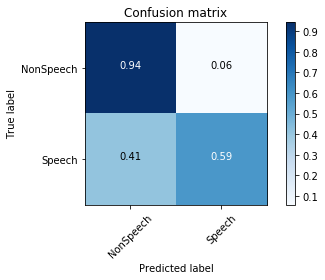

In [69]:
c_metrics = metrics.confusion_matrix(Test_Label,viterbi_result)
plot_confusion_matrix(cm = c_metrics, 
                      classes = target_names,
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)

In [131]:
import os
import muda

def DeformDataset(DatasetPath,OutputPath,DeformerBook):
    for item in DeformerBook:
        #Create directory for saving deformed dataset(original dataset excluded)
        dirName = OutputPath + '/' + item
        os.mkdir(dirName)
        deformer = DeformerBook[item]
        for root, dirs,files in os.walk(DatasetPath):
            for file in os.listdir(root):  
                if file.endswith(".jams"):
                    file_name = os.path.splitext(file)[0]

                    jams_path = root + '/' + file_name + '.jams'
                    audio_path = root + '/' + file_name + '.wav'

                    output_path = dirName + '/' + file_name
                    # Load an example audio file with annotation
                    j_orig = muda.load_jam_audio(jams_path, audio_path)            

                    #for j_new in pipeline.transform(j_orig):
                        #print(j_new)
                    for i, jam_out in enumerate(deformer.transform(j_orig)):
                        muda.save(output_path + '_deformed_{:02d}.wav'.format(i),
                                   output_path + '_deformed_{:02d}.jams'.format(i),
                                   jam_out)

                        #load scaper annotations
                        ann = jam_out.annotations.search(namespace='scaper')[0]
                        #Write new txt file
                        txt_path = output_path + '_deformed_{:02d}.txt'.format(i)
                        csv_data = []
                        for obs in ann.data:
                            if obs.value['role'] == 'foreground':
                                csv_data.append(
                                    [obs.time, obs.time+obs.duration, obs.value['label']])

                        with open(txt_path, 'w') as csv_file:
                            writer = csv.writer(csv_file, delimiter='\t')
                            writer.writerows(csv_data)



# Construct a deformation pipeline
pitch_shift_1 = muda.deformers.PitchShift(n_semitones=-1)
pitch_shift_2 = muda.deformers.PitchShift(n_semitones=1)
time_stretch = muda.deformers.RandomTimeStretch(n_samples=2,scale=0.3)
colored_noise = muda.deformers.ColoredNoise(n_samples=1,color=['white'])
drc = muda.deformers.DynamicRangeCompression(preset='speech')
#ir_convolution = muda.deformers.IRConvolution()

dataset_dir = os.getcwd() + '/AugmentedDataset/soundbanks'
output_dir = os.getcwd() + '/AugmentedDataset/augmentedsoundbanks'

deformers = {#'PitchShift1':pitch_shift_1,
             #'PitchShift2':pitch_shift_2,
             #'TimeStretched':time_stretch,
             #'ColoredNoise':colored_noise,
             'DynamicCompressed':drc}

DeformDataset(DatasetPath = dataset_dir,
             OutputPath = output_dir,
             DeformerBook = deformers)

In [158]:
def CreateDataset(Files_Dir,Parameters,Property,EventLabel='speech'):
    #Process all the .wav, .txt, in the assigned folder

    #Files_Dir: Target folder for saving all raw audio data
    #Parameters: Using  for processing audio files
    #Property:Create train/test/validation set
    #EventLabel: The label in string which indicate the class you want to learn,see sed_eval doc to see detail

    data = []
    labels = []

    #Calculate the Transition Matrix From Training set,saving the probability of each status transition
    SS = []#Speech to Speech
    NN = []#NonSpeech to NonSpeech
    SN = []#Speech to NonSpeech
    NS = []#NonSpeech to Speech

    file_index = 0
    for root, dirs,files in os.walk(Files_Dir):
        #.txt-based: which means processing txt first then find its corresponding .wav file

        #root_path,subfolders = root,dirs
        for file in os.listdir(root):
            if file.endswith('.txt'):
                file_path = root + '/' + file
                
                processed_filename =  os.path.splitext(file)[0]
                #Load Annotated Information
                annotated_event = sed_eval.io.load_event_list(file_path)
                target_event = sed_eval.util.event_list.filter_event_list(annotated_event, scene_label=None, event_label=EventLabel, filename=None)

                #Load Audio for feature extraction
                audio_file_name = os.path.splitext(file)[0] + '.wav'
                audio_file_path = root + '/' + audio_file_name
                feature_vector,audio_data, audio_sr = FeatureExtraction(audio_file_path,Parameters)

                #Using Annotation info to create the vector labels
                label_vector = CreateLabelVector(Data=audio_data,
                                                     EventList=target_event,
                                                     Parameters=Parameters,
                                                     LabelIndex=1)
                if feature_vector.shape[1] != len(label_vector):
                    print('===========Waring! Unmatched data size,will skip this file:==========')
                    print(file_path)
                    continue
                #Calculate the probability in the transition state matrix If data contains speech
                if sum(label_vector) != 0:
                    #probability of ss,nn,sn,ns; n=nonspeech, s = speech
                    p_ss, p_nn, p_sn, p_ns = ComputeStateTransition(label_vector)
                    SS.append(p_ss)
                    NN.append(p_nn)
                    SN.append(p_sn)
                    NS.append(p_ns)

                data.append([feature_vector,label_vector])
                file_index += 1

    #Transition Matrix:
    trans_matrix = np.array([[np.mean(SS),1 - np.mean(SS)],[1 - np.mean(NN),np.mean(NN)]])
    #Saving the transition Matrix
    np.save(os.getcwd()+'/JPNotebookExported/' + Property + '_TransitionMatrix.npy', trans_matrix)
    np.save(os.getcwd()+'/JPNotebookExported/' + Property + '_Dataset.npy', np.asarray(data))
    print(trans_matrix)

    return np.asarray(data),trans_matrix

#Create the deformed dataset
AugmentedDataset_dir = os.getcwd() + '/AugmentedDataset/augmentedsoundbanks'
DeformedTrainData,DeformedTrainTransMatrix = CreateDataset(Files_Dir = AugmentedDataset_dir,
                                            Parameters = Params,
                                            Property = 'DeformedTrain')

===========Waring! Unmatched data size,will skip this file:==========
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/AugmentedDataset/augmentedsoundbanks/TimeStretched/soundscape_train_bimodal824_deformed_00.txt
===========Waring! Unmatched data size,will skip this file:==========
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/AugmentedDataset/augmentedsoundbanks/TimeStretched/soundscape_train_bimodal1766_deformed_00.txt
===========Waring! Unmatched data size,will skip this file:==========
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/AugmentedDataset/augmentedsoundbanks/TimeStretched/soundscape_train_bimodal1366_deformed_01.txt
===========Waring! Unmatched data size,will skip this file:==========
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/AugmentedDataset/augmentedsoundbanks/TimeStretched/soundscape_train_bimodal1230_deformed_00.txt
===========Waring! Unmatched data size,will skip this file:==========
/Users/anderson675/Document

In [160]:
#Load the dataset
DeformedTrainSetPath = os.getcwd()+'/JPNotebookExported/DeformedTrain_Dataset.npy'

#Load Transition Matrix
deformed_train_transition_matrix = np.load(os.getcwd()+'/JPNotebookExported/DeformedTrain_TransitionMatrix.npy',allow_pickle=True)

#Load all the data and label
DeformedTrain,_,_ = DatasetLoader(DeformedTrainSetPath,ValidateSetPath,TestSetPath)
Deformed_Train_Data,Deformed_Train_Label = DeformedTrain['Data'], DeformedTrain['Label']

bestRF.fit(Deformed_Train_Data, Deformed_Train_Label)
Test_Data_path =  os.getcwd() + '/1_Dataset_Generate/audio/soundbanks/Test/generated/'
Prediction_Evaluation(Test_Data_path,bestRF,Params,test_transition_matrix)

(13128404, 40)
(13128404,)
(861138, 40)
(861138,)
(861138, 40)
(861138,)
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform198.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform601.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform167.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform173.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform615.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform629.txt
/Users/anderson675/Document

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform14.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform575.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform213.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform28.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform207.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform561.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform162.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform604.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform610.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform176.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform348.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform406.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform60.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform267.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform48.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform501.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform515.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform273.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform658.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform116.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform102.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform664.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform499.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform5.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform263.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform504.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform262.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform59.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform276.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform510.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform468.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform332.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform454.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform440.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform326.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform497.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform127.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform133.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform655.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform651.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform137.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform123.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform322.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform444.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform450.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform336.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform86.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform92.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform581.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform230.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform556.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform542.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform224.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform23.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform21.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform35.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform554.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform232.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform226.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform540.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform586.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform343.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform425.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform431.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform357.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform419.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform156.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform142.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform624.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform618.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform195.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/uniform/soundscape_test_uniform181.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal506.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal512.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal274.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal328.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal314.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal472.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal313.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal475.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal461.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal307.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal298.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal529.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal360.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal374.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal412.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal0.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal638.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal162.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal159.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal165.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal603.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal617.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal171.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal89.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal562.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal204.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal210.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal576.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal211.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal577.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal221.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal547.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal590.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal584.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal369.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal427.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal593.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal418.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal430.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal356.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal342.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal424.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal409.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal390.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal384.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal637.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal151.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal145.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal146.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal152.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal634.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal82.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal96.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal608.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/g

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal31.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal122.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal644.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal650.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal136.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal485.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal279.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal251.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal537.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal523.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal245.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal522.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal333.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal455.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal469.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal482.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal496.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/bimodal/soundscape_test_bimodal125.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal176.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal610.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal604.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal162.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal16.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal599.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soun

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal628.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal166.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal600.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal614.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal172.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal199.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/sou

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal664.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal102.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal116.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal89.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal62.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal76.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundb

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal74.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal100.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal114.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal128.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal464.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal302.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soun

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal661.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal113.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal649.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal98.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal67.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal73.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundb

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal254.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal532.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal268.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal283.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal297.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal56.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soun

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal41.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal55.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal82.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal96.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal121.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal647.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundba

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal642.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal124.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal130.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal656.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal1.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal468.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/sound

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal443.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal325.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal494.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal480.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal381.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal395.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/sou

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal355.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal341.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal427.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal194.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal180.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal619.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/sou

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal620.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal608.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal32.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal26.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal581.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal595.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/sound

/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal555.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal541.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal227.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal569.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal568.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/soundbanks/Test/generated/unimodal/soundscape_test_unimodal540.txt
/Users/anderson675/Documents/Thesis/scripts/jupyternotebook/1_Dataset_Generate/audio/sou

              precision    recall  f1-score   support

   NonSpeech       0.98      0.76      0.86    776802
      Speech       0.28      0.86      0.42     84336

   micro avg       0.77      0.77      0.77    861138
   macro avg       0.63      0.81      0.64    861138
weighted avg       0.91      0.77      0.81    861138

Normalized confusion matrix
[[0.75983327 0.24016673]
 [0.1376992  0.8623008 ]]


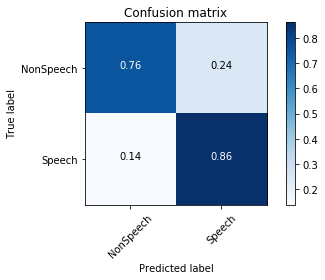

In [165]:
Prediction_Evaluation(Test_Data_path,bestRF,Params,test_transition_matrix)
pred_Test_prob = bestRF.predict_proba(Test_Data)[:,1]
viterbi_result = librosa.sequence.viterbi_binary(pred_Test_prob, test_transition_matrix, p_state=0.1, p_init=None).ravel()
target_names = ['NonSpeech', 'Speech']
print(metrics.classification_report(Test_Label, viterbi_result, target_names=target_names))
c_metrics = metrics.confusion_matrix(Test_Label,viterbi_result)
plot_confusion_matrix(cm = c_metrics, 
                      classes = target_names,
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)

In [ ]:
#Time Consuming! multiple grid search gonna be implemented:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 100, num = 15)]
# Number of features to consider at every split
max_features = ['auto', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 80, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#Original + Pitchshift
'''
#Create the deformed dataset
OP_AugmentedDataset_dir = os.getcwd() + '/AugmentedDataset/augmentedsoundbanks/OP'
DeformedTrainData,DeformedTrainTransMatrix = CreateDataset(Files_Dir = OP_AugmentedDataset_dir,
                                            Parameters = Params,
                                            Property = 'DeformedTrainOP')
'''                                            
#Load the dataset
OP_DeformedTrainSetPath = os.getcwd()+'/JPNotebookExported/DeformedTrainOP_Dataset.npy'

#Load Transition Matrix
OPdeformed_train_transition_matrix = np.load(os.getcwd()+'/JPNotebookExported/DeformedTrainOP_TransitionMatrix.npy',allow_pickle=True)

#Load all the data and label
OP_DeformedTrain,_,_ = DatasetLoader(OP_DeformedTrainSetPath,ValidateSetPath,TestSetPath)
OP_Deformed_Train_Data,OP_Deformed_Train_Label = OP_DeformedTrain['Data'], OP_DeformedTrain['Label']

# Use the random grid to search for best hyperparameters
# First create the base model to tune
OP_rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
OP_rf_random = RandomizedSearchCV(estimator = OP_rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=1, random_state=42, n_jobs = -1)
# Fit the random search model
OP_rf_random.fit(OP_Deformed_Train_Data, OP_Deformed_Train_Label)

OP_best_RF = OP_rf_random.best_estimator_
Prediction_Evaluation(Test_Data_path,OP_best_RF,Params,test_transition_matrix)
pred_Test_prob = OP_best_RF.predict_proba(Test_Data)[:,1]
viterbi_result = librosa.sequence.viterbi_binary(pred_Test_prob, test_transition_matrix, p_state=0.1, p_init=None).ravel()
target_names = ['NonSpeech', 'Speech']
print(metrics.classification_report(Test_Label, viterbi_result, target_names=target_names))
c_metrics = metrics.confusion_matrix(Test_Label,viterbi_result)
plot_confusion_matrix(cm = c_metrics, 
                      classes = target_names,
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)
#=================================================================================

(7758033, 40)
(7758033,)
(861138, 40)
(861138,)
(861138, 40)
(861138,)
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [166]:

#Original + Time Stretch
#Create the deformed dataset
OT_AugmentedDataset_dir = os.getcwd() + '/AugmentedDataset/augmentedsoundbanks/OT'
DeformedTrainData,DeformedTrainTransMatrix = CreateDataset(Files_Dir = OT_AugmentedDataset_dir,
                                            Parameters = Params,
                                            Property = 'DeformedTrainOT')
#Load Transition Matrix
OTdeformed_train_transition_matrix = np.load(os.getcwd()+'/JPNotebookExported/DeformedTrainOT_TransitionMatrix.npy',allow_pickle=True)

#Load all the data and label
OT_DeformedTrain,_,_ = DatasetLoader(OT_DeformedTrainSetPath,ValidateSetPath,TestSetPath)
OT_Deformed_Train_Data,OT_Deformed_Train_Label = OT_DeformedTrain['Data'], OT_DeformedTrain['Label']

# Use the random grid to search for best hyperparameters
# First create the base model to tune
OT_rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
OT_rf_random = RandomizedSearchCV(estimator = OT_rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=1, random_state=42, n_jobs = -1)
# Fit the random search model
OT_rf_random.fit(OT_Deformed_Train_Data, OT_Deformed_Train_Label)

OT_best_RF = OT_rf_random.best_estimator_
Prediction_Evaluation(Test_Data_path,OT_best_RF,Params,test_transition_matrix)
pred_Test_prob = OT_best_RF.predict_proba(Test_Data)[:,1]
viterbi_result = librosa.sequence.viterbi_binary(pred_Test_prob, test_transition_matrix, p_state=0.1, p_init=None).ravel()
target_names = ['NonSpeech', 'Speech']
print(metrics.classification_report(Test_Label, viterbi_result, target_names=target_names))
c_metrics = metrics.confusion_matrix(Test_Label,viterbi_result)
plot_confusion_matrix(cm = c_metrics, 
                      classes = target_names,
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)
#=================================================================================

#Original + All Stages
#Create the deformed dataset
OT_AugmentedDataset_dir = os.getcwd() + '/AugmentedDataset/augmentedsoundbanks/OA'
DeformedTrainData,DeformedTrainTransMatrix = CreateDataset(Files_Dir = OT_AugmentedDataset_dir,
                                            Parameters = Params,
                                            Property = 'DeformedTrainOA')
#Load Transition Matrix
OAdeformed_train_transition_matrix = np.load(os.getcwd()+'/JPNotebookExported/DeformedTrainOA_TransitionMatrix.npy',allow_pickle=True)

#Load all the data and label
OA_DeformedTrain,_,_ = DatasetLoader(OA_DeformedTrainSetPath,ValidateSetPath,TestSetPath)
OA_Deformed_Train_Data,OA_Deformed_Train_Label = OA_DeformedTrain['Data'], OA_DeformedTrain['Label']

# Use the random grid to search for best hyperparameters
# First create the base model to tune
OA_rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
OA_rf_random = RandomizedSearchCV(estimator = OA_rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=1, random_state=42, n_jobs = -1)
# Fit the random search model
OA_rf_random.fit(OA_Deformed_Train_Data, OA_Deformed_Train_Label)

OA_best_RF = OA_rf_random.best_estimator_
Prediction_Evaluation(Test_Data_path,OA_best_RF,Params,test_transition_matrix)
pred_Test_prob = OA_best_RF.predict_proba(Test_Data)[:,1]
viterbi_result = librosa.sequence.viterbi_binary(pred_Test_prob, test_transition_matrix, p_state=0.1, p_init=None).ravel()
target_names = ['NonSpeech', 'Speech']
print(metrics.classification_report(Test_Label, viterbi_result, target_names=target_names))
c_metrics = metrics.confusion_matrix(Test_Label,viterbi_result)
plot_confusion_matrix(cm = c_metrics, 
                      classes = target_names,
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)
#=================================================================================



[[0.98694433 0.01305567]
 [0.00395698 0.99604302]]
(7758033, 40)
(7758033,)
(861138, 40)
(861138,)
(861138, 40)
(861138,)
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
Prediction_Evaluation(Test_Data_path,OP_rf_random,Params,test_transition_matrix)

In [ ]:
Prediction_Evaluation(Test_Data_path,OT_rf_random,Params,test_transition_matrix)

In [ ]:
Prediction_Evaluation(Test_Data_path,OA_rf_random,Params,test_transition_matrix)